# Judging books by their cover using Flux.jl

Hi! Today I'll be showing you how you can use Flux to help classify books into different categories just from their covers.

The first thing we'll be doing is importing all the packages we need.<br/>
`Flux` will take care of our ML infrastructure, `Images` will allow us to process the image, `CSV` will allow us to extrapolate the data from csv files, and finally `Statistics` will be used to help calculate the accuracy using the `mean()` function.

In [2]:
using Flux, Images, CSV, Statistics

The following shows how we can read the csv file and checks out the first item to show you the structure of it.<br>
The following output represents the information we have of the first book.<br>
Column1 = Amazon Index<br>
Column2 = File Name<br>
Column3 = Image URL <br>
Column4 = Book Name<br>
Column5 = Author<br>
Column6 = Category Number<br>
Column7 = Category Name


In [3]:
data = CSV.File("judge-books/books.csv"; header=false)
first(data)

CSV.Row(1): (Column1 = "1588345297", Column2 = "1588345297.jpg", Column3 = "http://ecx.images-amazon.com/images/I/51l6XIoa3rL.jpg", Column4 = "With Schwarzkopf: Life Lessons of The Bear", Column5 = "Gus Lee", Column6 = 1, Column7 = "Biographies & Memoirs")

Next, we'll be checking out the length of the dataset for our reference.

In [4]:
length(data)

51300

Let's try to get the file name so that we can load it.

In [5]:
data[1][2]

"1588345297.jpg"

Interpolating the string containing the file name into the path of the image to load it.

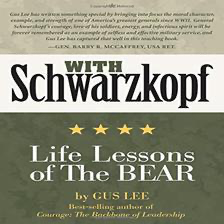

In [6]:
load("judge-books/images/$(data[1][2])")

Now, we are going to create a preprocessing function that will convert the image into grayscale and a floating vector of that (containing all the information) to be passed into the neural network.

In [7]:
preprocess(img) = vec(Float64.(Gray.(load("judge-books/images/$(img[2])"))))

preprocess (generic function with 1 method)

Creating a function that allows us to create a batch so that we can easily group our data together:<br>
Each image will have its floating vector and an array with its onehot label associated to itself.

In [8]:
function create_batch(r)
    xs = [preprocess(img) for img in data[r]]
    ys = [Flux.onehot(img[6]+1, 1:30) for img in data[r]]
    return (Flux.batch(xs), Flux.batch(ys))
end

create_batch (generic function with 1 method)

Using the function above to create a batch of the first 4000 images in the dataset.

In [9]:
trainbatch = create_batch(1:4000)

([0.7607843137254902 0.7568627450980392 … 0.0 0.4; 0.7647058823529411 0.6862745098039216 … 0.0 0.4; … ; 0.37254901960784315 0.8 … 0.0 0.6823529411764706; 0.37254901960784315 0.9607843137254902 … 0.0 0.6823529411764706], Bool[0 0 … 0 0; 1 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

Checking out the structure of the floating vectors in the batch of 4000 images.<br>
As you can see, the array has a size of 50176 items for each of the 4000 images. <br>
I'll be keeping a note of that number as that will determine the number of inputs we pass in to our neural network later.

In [10]:
trainbatch[1]

50176×4000 Array{Float64,2}:
 0.760784  0.756863  0.615686  …  0.0313725  0.807843  0.0  0.4     
 0.764706  0.686275  0.462745     0.0313725  0.780392  0.0  0.4     
 0.784314  0.709804  0.498039     0.0313725  0.792157  0.0  0.4     
 0.788235  0.701961  0.537255     0.0313725  0.807843  0.0  0.4     
 0.768627  0.694118  0.513725     0.0313725  0.803922  0.0  0.4     
 0.768627  0.709804  0.529412  …  0.0313725  0.803922  0.0  0.4     
 0.772549  0.686275  0.521569     0.0313725  0.811765  0.0  0.4     
 0.74902   0.705882  0.517647     0.0313725  0.803922  0.0  0.4     
 0.745098  0.694118  0.541176     0.0313725  0.8       0.0  0.403922
 0.745098  0.694118  0.533333     0.0313725  0.823529  0.0  0.403922
 0.745098  0.694118  0.529412  …  0.0313725  0.843137  0.0  0.407843
 0.745098  0.694118  0.521569     0.0313725  0.541176  0.0  0.407843
 0.745098  0.694118  0.521569     0.0313725  0.145098  0.0  0.407843
 ⋮                             ⋱                                    
 0.36

Checking out the structure of the array of onehot labels in the batch of 4000 images. <br>
Each image has 30 items associated to it, with 29 of them being 0 and 1 of them being 1. <br>
The index of the one and only 1 represents the category of the book, except that number needs to be subtracted by 1 because the categories range from 0-29, not 1-30.

In [11]:
trainbatch[2]

30×4000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  1
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  1  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0 

Now, we will be creating the model containing the neural network. As we have 50176 items associated with each image, that number will be the input. As we would like to know which category the book most likely belongs to, and the fact that there are 30 categories from 0-29, 30 is the number of outputs we'll be needing today. Now onto the architecture of the model, here we will be using the reLU activation function for the first Dense layer and an identify function for the third, before ending with the softmax output function.

In [12]:
model = Chain(Dense(50176, 512, relu), Dense(512, 64), Dense(64, 30, identity), softmax)

Chain(Dense(50176, 512, relu), Dense(512, 64), Dense(64, 30), softmax)

We are using the cross-entropy loss function.

In [13]:
loss(x,y) = Flux.crossentropy(model(x), y)

loss (generic function with 1 method)

We are using the Adam optimiser with a learning rate of 0.0001

In [14]:
opt = ADAM(0.0001)

ADAM(0.0001, (0.9, 0.999), IdDict{Any,Any}())

Setting up the accuracy similar to that of [this](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl#L23).

In [15]:
accuracy(x,y) = mean(Flux.onecold(model(x)).== Flux.onecold(y))

accuracy (generic function with 1 method)

Setting up the callback function that will be used when we are training the function to show the present loss and accuracy.

In [16]:
cb() = @show(loss(trainbatch...), accuracy(trainbatch...))

cb (generic function with 1 method)

In [17]:
@time Flux.train!(loss, params(model), Iterators.repeated(trainbatch, 1), opt; cb = Flux.throttle(cb, 1))

loss(trainbatch...) = 10.965167f0
accuracy(trainbatch...) = 0.08525
 51.497023 seconds (1.04 G allocations: 22.411 GiB, 7.80% gc time)


Now we can train the model. Here, we'll be using the `Iterators.repeated` function to repeat the training process 360 times as well as using `Flux.throttle` to print the loss and accuracy every 60 seconds.

In [18]:
Flux.train!(loss, params(model), Iterators.repeated(trainbatch, 180), opt; cb = Flux.throttle(cb, 60))

loss(trainbatch...) = 17.33493f0
accuracy(trainbatch...) = 0.058
loss(trainbatch...) = 9.069943f0
accuracy(trainbatch...) = 0.0485
loss(trainbatch...) = 5.563376f0
accuracy(trainbatch...) = 0.0355
loss(trainbatch...) = 4.8754497f0
accuracy(trainbatch...) = 0.0385
loss(trainbatch...) = 4.1969633f0
accuracy(trainbatch...) = 0.05425
loss(trainbatch...) = 3.6376808f0
accuracy(trainbatch...) = 0.0425
loss(trainbatch...) = 3.5965037f0
accuracy(trainbatch...) = 0.0345
loss(trainbatch...) = 3.3209286f0
accuracy(trainbatch...) = 0.0955
loss(trainbatch...) = 3.3053942f0
accuracy(trainbatch...) = 0.093
loss(trainbatch...) = 3.2756648f0
accuracy(trainbatch...) = 0.09375
loss(trainbatch...) = 3.2393825f0
accuracy(trainbatch...) = 0.09825
loss(trainbatch...) = 3.2274425f0
accuracy(trainbatch...) = 0.106
loss(trainbatch...) = 3.2144039f0
accuracy(trainbatch...) = 0.10725
loss(trainbatch...) = 3.2027128f0
accuracy(trainbatch...) = 0.10075
loss(trainbatch...) = 3.188115f0
accuracy(trainbatch...) = 0.11

In [74]:
Flux.train!(loss, params(model), Iterators.repeated(trainbatch, 180), opt; cb = Flux.throttle(cb, 60))

loss(trainbatch...) = 2.7598846f0
accuracy(trainbatch...) = 0.26825
loss(trainbatch...) = 2.7465343f0
accuracy(trainbatch...) = 0.27075
loss(trainbatch...) = 2.7333057f0
accuracy(trainbatch...) = 0.282
loss(trainbatch...) = 2.7183459f0
accuracy(trainbatch...) = 0.28525
loss(trainbatch...) = 2.7092032f0
accuracy(trainbatch...) = 0.27625
loss(trainbatch...) = 2.6927774f0
accuracy(trainbatch...) = 0.299
loss(trainbatch...) = 2.6804216f0
accuracy(trainbatch...) = 0.29175
loss(trainbatch...) = 2.6631036f0
accuracy(trainbatch...) = 0.3035
loss(trainbatch...) = 2.6506827f0
accuracy(trainbatch...) = 0.314
loss(trainbatch...) = 2.6370416f0
accuracy(trainbatch...) = 0.31275
loss(trainbatch...) = 2.6238384f0
accuracy(trainbatch...) = 0.31825
loss(trainbatch...) = 2.6093378f0
accuracy(trainbatch...) = 0.33425
loss(trainbatch...) = 2.5947564f0
accuracy(trainbatch...) = 0.334
loss(trainbatch...) = 2.5829868f0
accuracy(trainbatch...) = 0.334
loss(trainbatch...) = 2.5783112f0
accuracy(trainbatch...) =

As you can see below, our loss is now 2.18 and the accuracy is 50.3%.

In [154]:
loss(trainbatch...)

2.1843717f0

In [155]:
accuracy(trainbatch...)

0.50325

Now that we have the model trained, we can use the other books in the dataset to test our model and give a prediction. I'll be testing it out on the 5000th image in the dataset, which belongs to category 2, "Business & Money". Let's load the image to see what it looks like.

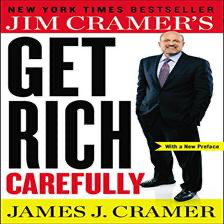

In [156]:
load("judge-books/images/$(data[5000][2])")

The array below returns the percentage certainty the model has for each of the 30 categories, in order. The first one corresponds to the 0th category, the second one to the 1st category, and so on...

In [157]:
testprediction = model(preprocess(data[5000]))

30-element Array{Float32,1}:
 0.06904125   
 0.0013687051 
 0.30564067   
 0.0019003467 
 0.0122752255 
 0.00063050323
 0.014400939  
 0.00066149054
 0.044060275  
 0.0011265653 
 0.00024397735
 0.005299801  
 0.003381016  
 ⋮            
 0.00074706454
 0.0004789304 
 0.008010443  
 0.019767081  
 0.0015127813 
 0.42793602   
 0.0020457897 
 0.0016720602 
 0.0029231526 
 0.010123464  
 0.03700547   
 0.017807292  

We can sort the previous array to see what the model predicts the category to be and its percentage, from highest to lowest.

In [158]:
sorted = sort(testprediction, rev=true)

30-element Array{Float32,1}:
 0.42793602   
 0.30564067   
 0.06904125   
 0.044060275  
 0.03700547   
 0.019767081  
 0.017807292  
 0.014400939  
 0.0122752255 
 0.010123464  
 0.008010443  
 0.005299801  
 0.0048549897 
 ⋮            
 0.0016720602 
 0.0015869794 
 0.0015127813 
 0.0013687051 
 0.0011265653 
 0.0008684021 
 0.00074706454
 0.00066149054
 0.00063050323
 0.0004938163 
 0.0004789304 
 0.00024397735

Let's get the highest value and search for its index in the prediction, but remember to subtract 1 from it because the categories are from 0-29 whereas the indices are from 1-30.

In [159]:
sorted[1]

0.42793602f0

In [160]:
findall(x -> x==sorted[1], testprediction)[1]-1

23

Now, the model has predicted the book to be in category 23, which is "Science & Math", with a 43% certainty. Unfortunately that's not the category of the book, but I have to say that it is sort of related to Math, so that's quite close. But let's look at the second highest prediction and percentage and see whether that's correct.

In [161]:
sorted[2]

0.30564067f0

In [162]:
findall(x -> x==sorted[2], testprediction)[1]-1

2

Yeah! The model has predicted it second in category 2, "Business & Money", which is exactly the category the book belongs to, with a certainty of 31%. Not bad at all!

### thanks for reading :)
### written by kfung